#### This notebook finds a dynamic factorization of transition dynamics / SCM.

Unfortunately there are many loss terms, and it is quite brittle to hparams.

Maybe there is a better way to do statistical independence test than learning to predict next step using squared error loss.

In [1]:
import numpy as np
np.random.seed(55)
import torch
from structured_transitions import gen_samples_dynamic, TransitionsData, MixtureOfMaskedNetworks

In [2]:
BATCH_SIZE = 2000
MASK_REGULARIZATION_COEFFICIENT = 1e-3
WEIGHT_LOSS_COEFFICIENT = 1e-3
ATTENTION_LOSS_COEFFICIENT = 1e-3
WEIGHT_DECAY = 0.
SPLITS = [3, 3, 3] # this is the factorization
dev = 'cuda' if torch.cuda.is_available() else 'cpu'

global_interactions, fns, samples = gen_samples_dynamic(num_seqs=1500, seq_len=10, 
                                                        splits=SPLITS, epsilon=1.5) # 15000 samples
print('Total global interactions: {}/{}'.format(global_interactions, len(samples[0])))
dataset = TransitionsData(samples)
tr = TransitionsData(dataset[:int(len(dataset)*5/6)])
te = TransitionsData(dataset[int(len(dataset)*5/6):])

train_loader = torch.utils.data.DataLoader(tr, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, drop_last=True)
test_loader  = torch.utils.data.DataLoader(te, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, drop_last=True)

Total global interactions: 2296.0/15000


In [3]:
K = len(SPLITS)

def laplacian(A, device=None):
  """
  My implementation; w_ij = -w_ij for i != j; w_ii = sum_{j != i} w_ij
  A bit slower than Scipy's for numpy arrays. 
  
  Works for both numpy array and torch tensor. 
  
  Note that this will be a differentiable function of A.
  Note that Laplacian at most rank n-1. 
  """
  if device is not None:
    assert torch.is_tensor(A)
    I = torch.eye(len(A), device=device)
  else:
    eye = torch.eye if torch.is_tensor(A) else np.eye
    I = eye(len(A))
  return (I - 1) * A + I * ((1-I)*A).sum(0, keepdims=True)

def low_rank_approx(A, rank):
  """
  Uses PCA to compute a low rank approximation to A.
  """
  assert rank <= len(A)
  U, S, V = torch.svd(A)
  return torch.mm(torch.mm(U[:,:rank], torch.diag(S[:rank])), V[:,:rank].t())

import torch.nn.functional as F

In [4]:
NUM_C = 3

model = MixtureOfMaskedNetworks(in_features=sum(SPLITS), out_features=sum(SPLITS), num_components=NUM_C,
                      num_hidden_layers=2, num_hidden_units=256).to(dev)

opt = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=WEIGHT_DECAY)
pred_criterion = torch.nn.MSELoss()
mask_criterion = torch.nn.L1Loss()

for epoch in range(250):
  total_pred_loss, total_mask_loss, total_weight_loss, total_attn_loss = 0., 0., 0., 0.
  for i, (x, y) in enumerate(train_loader):
    pred_y, mask, attn = model.forward_with_mask(x.to(dev))
    pred_loss = pred_criterion(y.to(dev), pred_y)
    
    proportions = (attn.sum(0)/1000).cpu().detach().numpy()
    mask_loss = 0
    for c, p in zip(model.components, proportions):
      mask = c.mask
      sym_mask = mask + mask.T
      L = laplacian(sym_mask, device=dev)
      low_rank_target = low_rank_approx(L, len(L) - K).detach()
      mask_loss += p * MASK_REGULARIZATION_COEFFICIENT*F.l1_loss(torch.log(1.+mask), torch.zeros_like(mask))
      mask_loss += p * MASK_REGULARIZATION_COEFFICIENT*F.l1_loss(L, low_rank_target)
    
    attn_loss = ATTENTION_LOSS_COEFFICIENT * torch.sqrt(attn).mean()
    
    weight_loss = 0
    for param in model.parameters():
      weight_loss += mask_criterion(param, torch.zeros_like(param))
    weight_loss *= WEIGHT_LOSS_COEFFICIENT
    
    total_pred_loss += pred_loss
    total_mask_loss += mask_loss
    total_attn_loss += attn_loss
    total_weight_loss += weight_loss
    
    loss = pred_loss + mask_loss + attn_loss + weight_loss
    model.zero_grad()
    loss.backward()
    opt.step()
  if epoch % 25 == 0:
    print('Epoch {} done! Pred: {:.5f}, Mask: {:.5f}, Attn: {:.5f}, Weight: {:.5f}'.\
        format(epoch, total_pred_loss / i, total_mask_loss / i, total_attn_loss / i, total_weight_loss / i))

Epoch 0 done! Pred: 0.04347, Mask: 0.03515, Attn: 0.00069, Weight: 0.00210
Epoch 25 done! Pred: 0.00348, Mask: 0.00315, Attn: 0.00067, Weight: 0.00159
Epoch 50 done! Pred: 0.00267, Mask: 0.00169, Attn: 0.00068, Weight: 0.00134
Epoch 75 done! Pred: 0.00228, Mask: 0.00121, Attn: 0.00068, Weight: 0.00117
Epoch 100 done! Pred: 0.00204, Mask: 0.00099, Attn: 0.00068, Weight: 0.00106
Epoch 125 done! Pred: 0.00189, Mask: 0.00084, Attn: 0.00068, Weight: 0.00097
Epoch 150 done! Pred: 0.00179, Mask: 0.00074, Attn: 0.00068, Weight: 0.00090
Epoch 175 done! Pred: 0.00171, Mask: 0.00067, Attn: 0.00068, Weight: 0.00084
Epoch 200 done! Pred: 0.00165, Mask: 0.00062, Attn: 0.00068, Weight: 0.00079
Epoch 225 done! Pred: 0.00158, Mask: 0.00059, Attn: 0.00068, Weight: 0.00074


In [5]:
for c in model.components:
  m = c.mask.detach().cpu().numpy()
  m[m < 0.02] = 0
  print(m.round(2))
  print('*')

[[0.2  0.13 0.25 0.08 0.31 0.   0.04 0.07 0.  ]
 [0.52 0.73 0.2  0.24 0.63 0.   0.03 0.09 0.  ]
 [0.2  0.19 0.16 0.16 0.42 0.   0.06 0.13 0.  ]
 [0.08 0.04 0.07 1.08 0.76 0.   0.02 0.06 0.  ]
 [0.04 0.   0.   1.11 0.44 0.   0.   0.06 0.  ]
 [0.   0.   0.   0.   0.28 0.   0.   0.   0.  ]
 [0.06 0.04 0.08 0.21 0.21 0.   0.06 0.14 0.  ]
 [0.07 0.02 0.05 0.12 0.14 0.   0.03 0.12 0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.  ]]
*
[[0.79 0.72 0.5  0.33 0.17 0.05 0.57 0.39 0.05]
 [1.01 1.02 0.4  0.3  0.15 0.12 0.47 0.38 0.08]
 [0.87 0.85 0.43 0.33 0.12 0.15 0.62 0.34 0.09]
 [0.39 0.21 0.21 0.32 0.2  0.06 0.31 0.37 0.12]
 [0.34 0.2  0.2  0.39 0.29 0.11 0.39 0.38 0.06]
 [0.04 0.05 0.09 0.08 0.15 0.11 0.1  0.14 0.15]
 [0.78 0.3  0.38 0.38 0.25 0.05 0.92 0.58 0.13]
 [0.8  0.23 0.32 0.36 0.24 0.02 0.65 0.68 0.2 ]
 [0.43 0.11 0.16 0.22 0.12 0.09 0.36 0.26 0.21]]
*
[[0.29 0.22 0.2  0.21 0.   0.27 0.24 0.16 0.  ]
 [0.42 0.34 0.28 0.39 0.   0.28 0.15 0.18 0.  ]
 [0.5  0.6  0.3  0.41 0.   0.38 0.

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

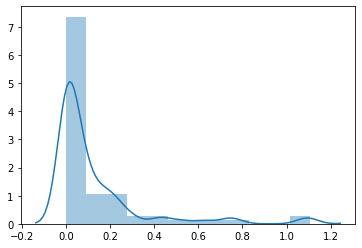

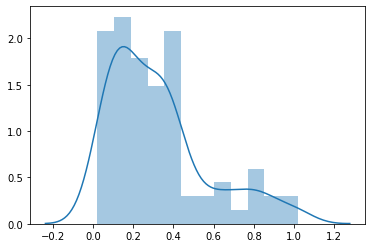

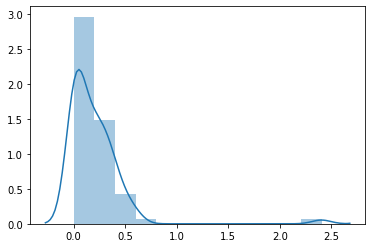

In [7]:
for c in model.components:
  m = c.mask.detach().cpu().numpy()
  sns.distplot(m.reshape(-1), bins=12)
  plt.show()